# Cross Entropy Method in Off-Policy Monte Carlo Control

# Importance Sampling

* General technique to estimate an unknown distribution 
* Particularly useful, in the case of rare events. We can use the behaviour distribution to overweights the rare events.

* The relative probability of the trajectory under the target and behaviour policy is given by

\begin{eqnarray}
\rho^T_t &=& \frac{\prod_{k=1}^{T-1} \pi(A_k|S_k) p(S_{k+1}|S_k,A_k)}{\prod_{k=1}^{T-1} \mu(A_k|S_k) p(S_{k+1}|S_k,A_k)} \\
&=& \prod_{k=t}^{T-1} \frac{\pi(A_k|S_k)}{\mu(A_k|S_k)}
\end{eqnarray}

* Note that we don't need to know $p(S_{k+1}|S_k,A_k)$.
* We could either scaled the return by $\rho_t$ and average them or as in the off-policy MC control do a weighted average.

# Simulation

* Variance reduction: if we can observe more good draws from the behaviour policy it would reduce our variance.
* Could we do better than drawing completely random policies?

# Cross Entropy (CE) method

CE is a general framework that can be applied to multiple optimization problems. It is an iterative algorithm that can be divided as

* Generate $N$ random data samples (trajectories) according to a mechanism (policy).
* Update the parameters of the random mechanism based on the data to produce "better" samples in the next iteration.




## Rare Event Case

Suppose being interested in $P(S(X) \geq \gamma) \approx 10^{-5}$ under $f(\cdot;u)$ i.e.

\begin{eqnarray}
l &=& E_u I_{\{S(X) \geq \gamma\}}
\end{eqnarray}

Using MC method

\begin{eqnarray}
\hat{l} &=& \frac{1}{N} \sum_{i=1}^N I_{\{S(X_i) \geq \gamma\}}
\end{eqnarray}

Alternatively using IS density $g$

\begin{eqnarray}
\hat{l} &=& \frac{1}{N} \sum_{i=1}^N I_{\{S(X_i)\geq \gamma\}} \frac{f(X_i;u)}{g(X_i)}
\end{eqnarray}

where the variance is minimize at $g^* = \frac{I_{\{S(X_i) \geq gamma\}} f(x;u)}{l}$, since $I_{\{S(X_i) \geq gamma\}} \frac{f(X_i;u)}{g*(X_i)} = l$, where $l$ is a constant.

$l$ is unknown and it is convenient to choose $g$ from the family $f(\cdot|v)$. We can minimize the distance between $f(\cdot|v)$ and $g*$ using the KL divergence.

The algorithm roughly goes as

* Let $\gamma_t < \gamma$ such that $P_{v_{t-1}}(S(X) \geq \gamma_t) \geq \varphi$
* Minimize $KL(g^*, f(\cdot; v_t))$

where $X \sim f(\cdot| v_{t-1})$.

[see Rubinstein 2005 for full example]

## CE Algorithm for MDP

Generate $N$ tajectories, $X_1,\ldots, X_N$, using $P_t$, where the $s$-th row of the matrix P gives you the probability over actions.

Given the $N$ trajectories and their scores, one can update the policy matrix as:

\begin{eqnarray}
\hat{p}_{t,sa} &=& \frac{\sum_{k=1}^N I_{\{\hat{S}(X_k) \geq \hat{\gamma}_{t,s}\}} I_{X_k \in \mathcal{X}_{sa}}}{\sum_{k=1}^N I_{\{\hat{S}(X_k) \geq \hat{\gamma}_{t,s}\}} I_{X_k \in \mathcal{X}_{s}}}
\end{eqnarray}

We can use smooth updating 

\begin{eqnarray}
p_t = \alpha p_t + (1-\alpha) p_{t-1}
\end{eqnarray}

# Off-Policy Monte Carlo Control

* Use MC control to learn the optimal policy.
* We observe a behavior policy, $\mu$, from which we try to learn our target policy, $\pi$.
* The behaviour policy $\mu$ is a soft, while the target policy $\pi$ is greedy.
* We require that if $\pi(a|s) > 0$ it implies that $\mu(a|s) > 0$.

![title](MCControl.png)

In [1]:
%matplotlib inline

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pdb
import sys

from collections import defaultdict

#Helper functions from https://github.com/dennybritz/reinforcement-learning
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

env = BlackjackEnv()

In [2]:
def plotPolicy(pi, title="Policy"): 
    min_x = 11#min(k[0] for k in pi.keys())
    max_x = max(k[0] for k in pi.keys())
    min_y = min(k[1] for k in pi.keys())
    max_y = max(k[1] for k in pi.keys())
    
    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)
    
    Z_noace = np.apply_along_axis(lambda _: pi[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: pi[(_[0], _[1], True)], 2, np.dstack([X, Y]))
    
    def plot_heatmap(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        #ax = fig.add_subplot(111, projection='polar')
        plt.pcolormesh(Y, X, Z, vmin=0, vmax=1.0)
        plt.colorbar() #need a colorbar to show the intensity scale
        plt.title(title)
        plt.show()
        
    plot_heatmap(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_heatmap(X, Y, Z_ace, "{} (Usable Ace)".format(title))

In [3]:
def computeGamma(episodes, rewards, p=0.97):
    distArray = defaultdict(lambda: [])
    j = 0
    for episode in episodes:   
        for s, _, _ in episode:
            distArray[s].append(rewards[j])
        j += 1
    
    gamma = defaultdict(lambda: 0.0)
    
    for k, v in distArray.iteritems():
        gamma[k] = np.percentile(distArray[k], p*100)
    
    return gamma
        

In [4]:
def generateTrajectory(P, env, N=100, epsilon=0.1):
    """
    input: n x m matrix P
    output:: total reward of the trajectory
    """
    episodes = []
    rewards = []
    for i in range(N):
        fin = False
        s = env.reset()
        episode = []
        r_tot = 0
        for t in range(100):
            if np.random.rand(1) < epsilon:
                a = np.random.choice(np.arange(env.action_space.n), p=np.ones(env.action_space.n)/env.action_space.n)
            else:
                a = np.random.choice(np.arange(env.action_space.n), p=P[s])
            s1,r,fin,_ = env.step(a) 
            r_tot += r
            episode.append((s, a, r))
            if fin:
                break
            s = s1
            
        episodes.append(episode)
        rewards.append(r_tot)
    return episodes, rewards
   
    


def updatePolicy(episodes, rewards, P, alpha=0.7):
    """
    N strategies X1, ..., XN and their scores SX1, ..., SXN
    """
    gamma_t = computeGamma(episodes, rewards)
    num = defaultdict(lambda: np.zeros(env.action_space.n))
    denom = defaultdict(lambda: np.zeros(env.action_space.n))
    j = 0
    for episode in episodes:
        if rewards[j] >= 0.: 
            for s, a, _ in episode:
                if rewards[j] >= gamma_t[s]:
                    num[s][a] += 1.
                    denom[s] += 1.
        j += 1
    for k, _ in denom.iteritems():
        P[k] += alpha*(num[k]/denom[k]-P[k])
    return P   

In [5]:
def offPolicyMCControl(nb_iter, epsilon=0.1, Vtrue=np.nan, computeMSE=True, gamma=1.0, CE=False, N=int(5e3)):
    MSE = np.zeros(nb_iter)
    Q = defaultdict(lambda: -np.ones(env.action_space.n))
    pi = defaultdict(lambda: np.ones(1))
    V = defaultdict(lambda: np.zeros(1))
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    P = defaultdict(lambda: np.ones(env.action_space.n)/env.action_space.n)
    j = 0
    for i in range(nb_iter/N):
        episodes, rewards = generateTrajectory(P, env, N=N, epsilon=epsilon)
        for episode in episodes:
            G = 0
            W = 1 # the importance sampling weight
            for t in range(len(episode))[::-1]:
                s, a, r = episode[t]
                G = gamma*G + r
                C[s][a] += W # cumulative weights of the n-1 returns
                Q[s][a] += (W/C[s][a])*(G-Q[s][a]) # incremental implementation
                pi[s] = np.argmax(Q[s])
                V[s] = np.max(Q[s])
                if a != pi[s]: # prob of action under the target policy is 0
                    break
                W = W*1./(epsilon*0.5 + (1-epsilon)*P[s][a]) # actions can be sampled randomly
            
            if computeMSE:
                MSE[j] = MSE_valueFunction(V, Vtrue)
            else:
                MSE = 0
            j += 1
            
        if CE:
            P = updatePolicy(episodes, rewards, P)
    return pi, V, MSE

def MSE_valueFunction(V, Vtrue):
    cost = 0
    for k, v in Vtrue.iteritems():
        if k in V:
            cost += (V[k]-v)**2
        else:
            cost += (v)**2
    return cost

In [6]:
_, Vtrue, _ = offPolicyMCControl(int(1e6), CE=False, computeMSE=False)

![title](Blackjack.png)

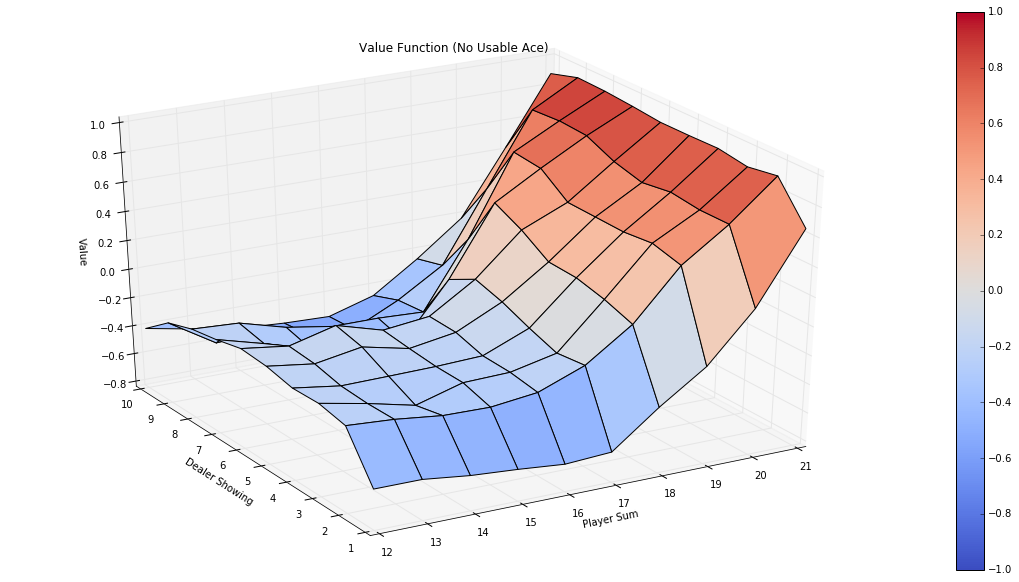

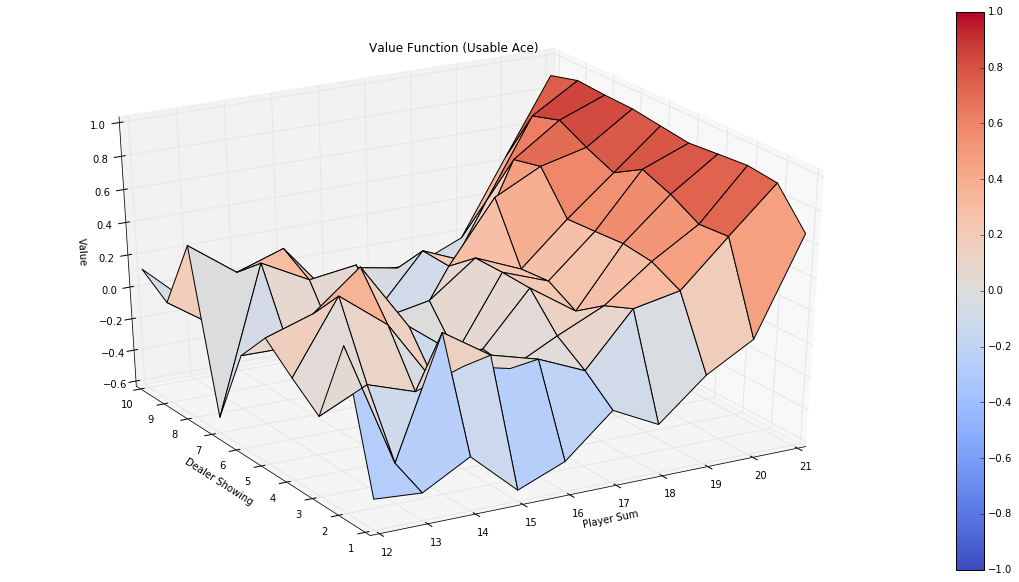

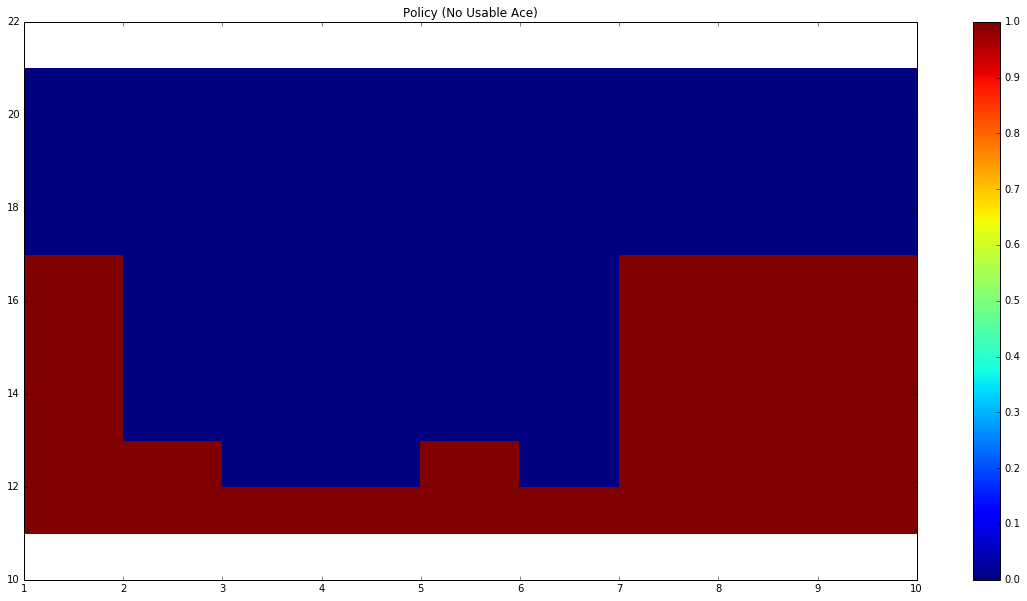

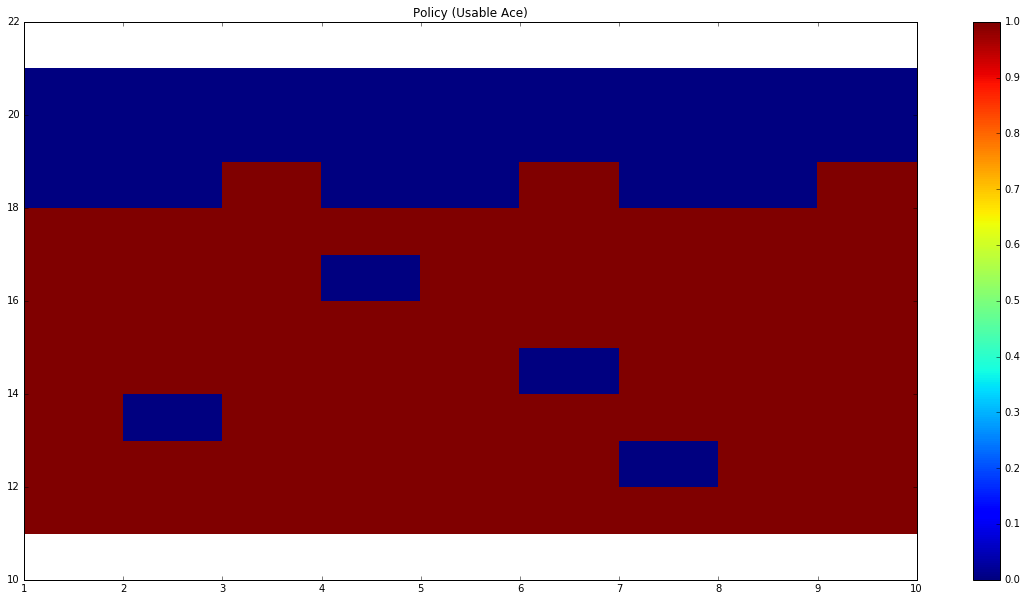

In [7]:
pi, V, MSE1 = offPolicyMCControl(int(2e5), CE=False, Vtrue=Vtrue)
plotting.plot_value_function(V)
plotPolicy(pi)

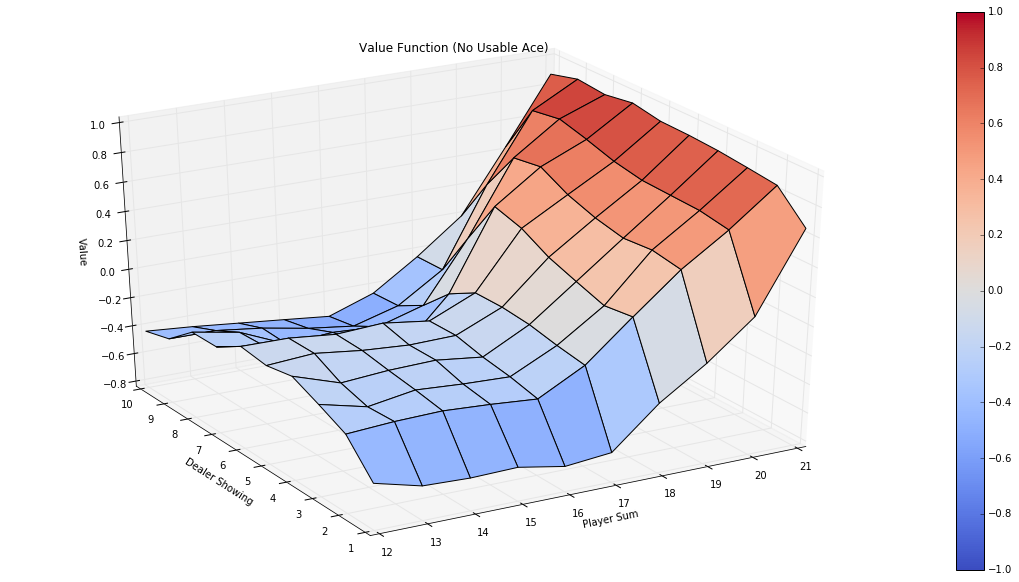

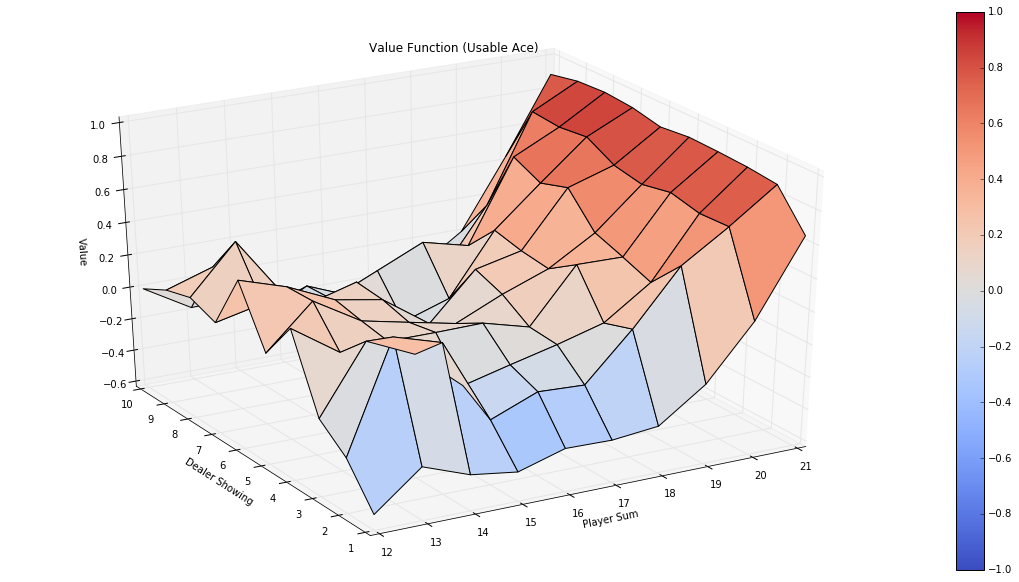

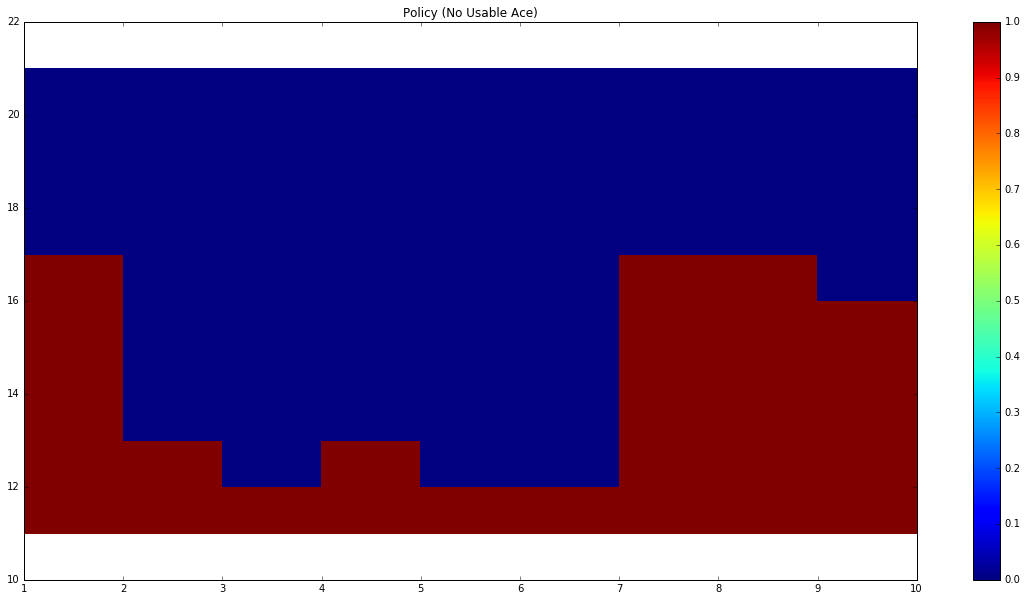

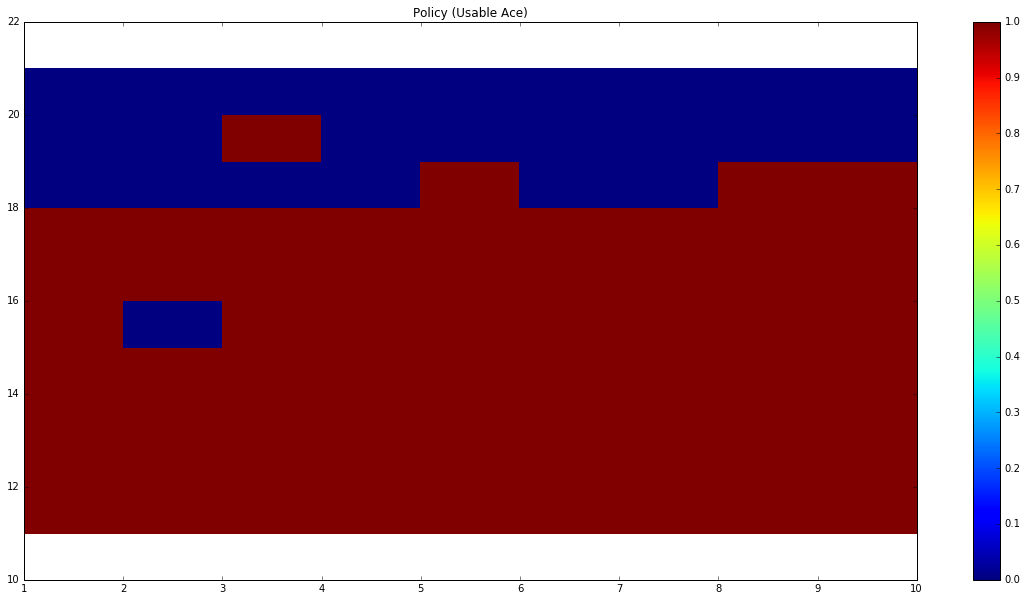

In [8]:
pi, V, MSE2 = offPolicyMCControl(int(2e5), CE=True, Vtrue=Vtrue)
plotting.plot_value_function(V)
plotPolicy(pi)

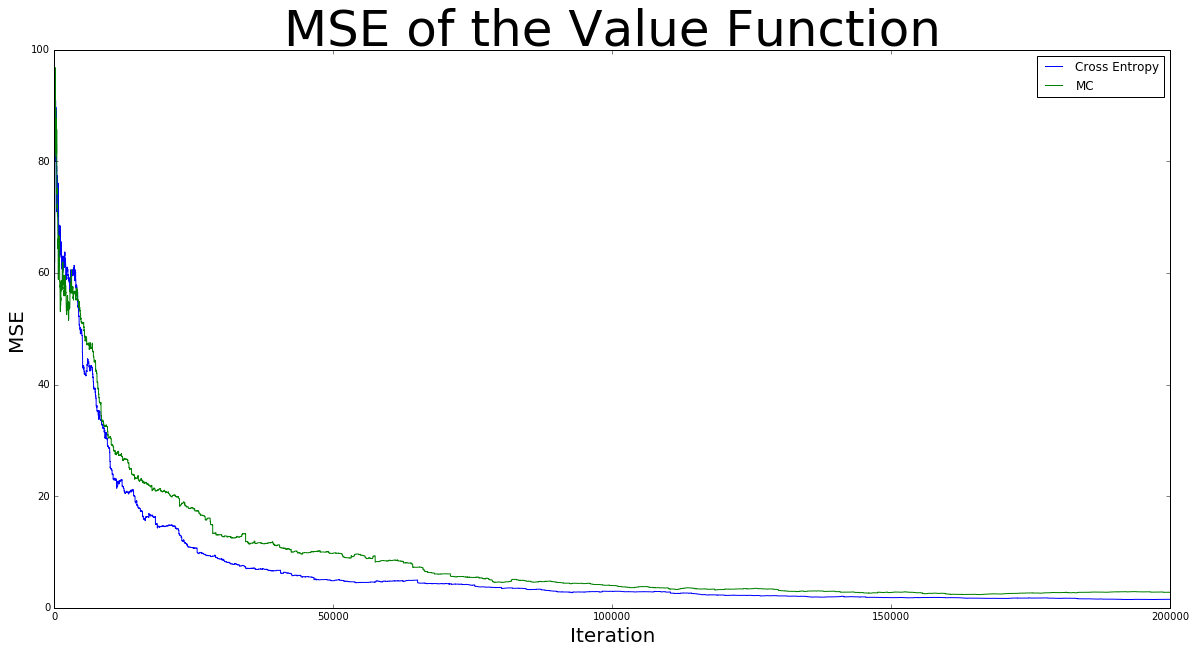

In [9]:
fig = plt.figure(figsize=(20, 10))

CE, = plt.plot(MSE2, label="Cross Entropy")
MC, = plt.plot(MSE1, label="MC")

plt.title("MSE of the Value Function", fontsize=50)
ax = fig.add_subplot(111)
ax.set_xlabel('Iteration',fontsize = 20)
ax.set_ylabel('MSE', fontsize = 20)

plt.legend(handles=[CE, MC])
plt.show()